# Descarga de datos

In [9]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('../data/steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

# Carga de datos and y configuración de los gráficos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
fname = []
for j in range(3):
  fname.append('../data/steinmetz_part%d.npz'%j)
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('../data/steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
  
# @title Figure settings
from matplotlib import rcParams
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Extracción y reestructuración de datos relevantes

In [2]:
session = alldat[25]
# session 25 neuron x trial x activation
data = session['spks']
print(data.shape) # no puedo usar PCA es tridimensional, neurona x trial x activation

# agrupo por slots de tiempo
window_size = 10
stride = 1

num_windows = (data.shape[2] - window_size) // stride + 1

windowed_data = []

for i in range(num_windows):
    window_data = data[:, :, i * stride:i * stride + window_size]
    window_avg = np.mean(window_data, axis=2)
    windowed_data.append(window_avg)

data_avg = np.stack(windowed_data, axis=2)
print(data_avg.shape)
flattened_data = data_avg.reshape(data_avg.shape[0], -1).T
print(flattened_data.shape)

(1056, 178, 250)
(1056, 178, 241)
(42898, 1056)


# PCA

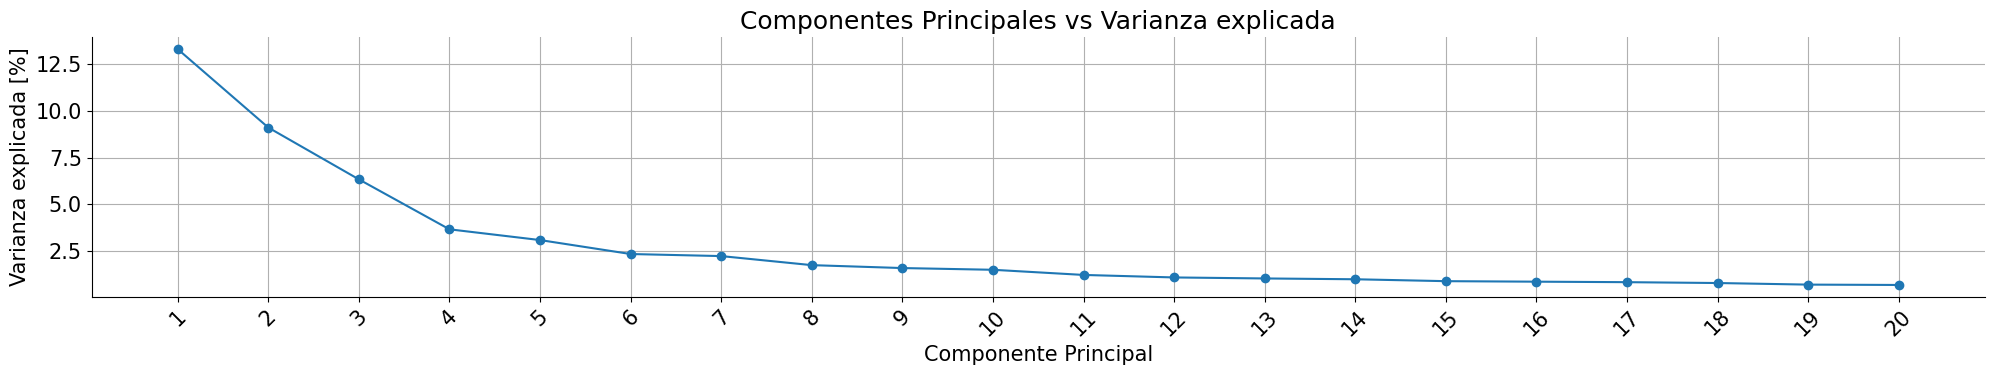

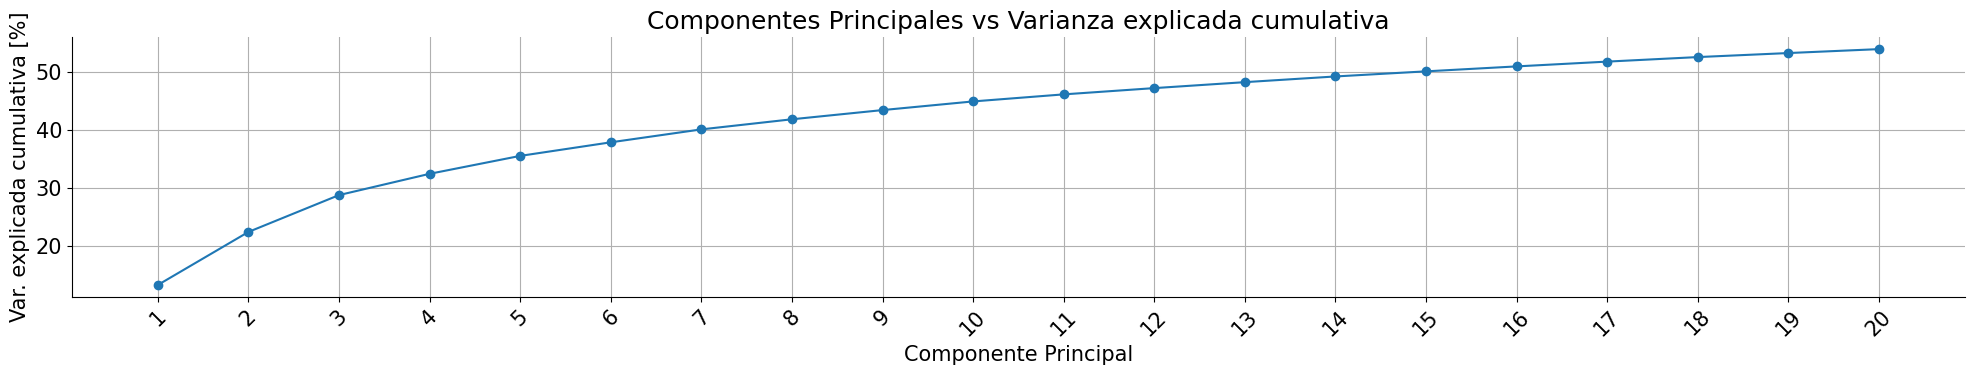

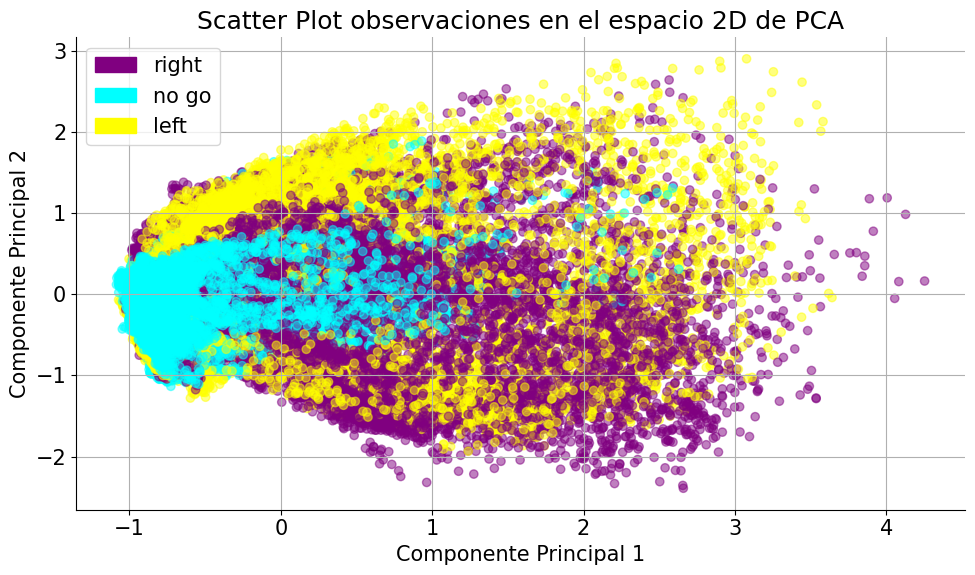

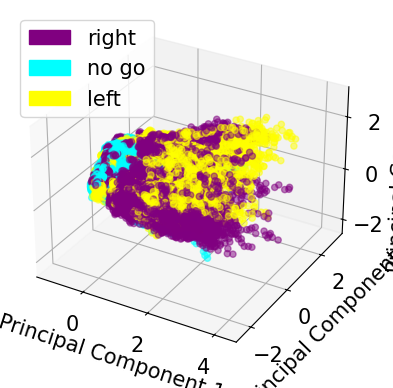

In [36]:

pca = PCA(20)
# mouse 1
pca_results = pca.fit_transform(flattened_data)
# Explained variance vs Principal component
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance*100, marker='o')
plt.xticks(range(1, len(explained_variance) +1), rotation = 45)
plt.xlabel("Componente Principal")
plt.ylabel("Varianza explicada [%]")
plt.title("Componentes Principales vs Varianza explicada")
plt.grid(True)
plt.show()


cumulative_variance = np.zeros(explained_variance.shape)
for i in range(len(explained_variance)):
    for j in range(0, i+1):
        cumulative_variance[i] += explained_variance[j]

# Cumulative variance vs Principal component
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance*100, marker='o')
plt.xticks(range(1, len(cumulative_variance) +1), rotation = 45)
plt.xlabel("Componente Principal")
plt.ylabel("Var. explicada cumulativa [%]")
plt.title("Componentes Principales vs Varianza explicada cumulativa")
plt.grid(True)
plt.show()


colores = []

for i in range(len(flattened_data)):
    match(session['response'][i // 241]): # 241 timebins x trial
        case -1: colores.append('purple')
        case 0: colores.append('cyan')
        case 1: colores.append('yellow')

# PC1 vs. PC2
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0],  # PCA1
            pca_results[:, 1],  # PCA2 
            alpha=0.5,          # Transparencia 
            c=colores          # asignacion de colores
            )          
plt.legend(handles=[plt.Rectangle((0,0),1,1, color='purple'), 
                    plt.Rectangle((0,0),1,1, color='cyan'),
                    plt.Rectangle((0,0),1,1, color='yellow')],
           labels=['right', 'no go', 'left'])
plt.title('Scatter Plot observaciones en el espacio 2D de PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.legend(handles=[plt.Rectangle((0,0),1,1, color='purple'), 
                    plt.Rectangle((0,0),1,1, color='cyan'),
                    plt.Rectangle((0,0),1,1, color='yellow')],
           labels=['right', 'no go', 'left'])

ax.scatter(pca_results[:, 0], pca_results[:, 1], pca_results[:, 2], c = colores, alpha=0.5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()


##### Al hacer el gráfico PCA1 vs. PCA2 se puede ver que hay clústers según cuál era la posición de la sección con contraste. Cuando tenía que hace una acción, en este caso mover el contraste al centro (color amarillo o violeta) hay muchos más puntos avanzados en el eje X, comparado con la poca amplitud que presentan cuando es un "no go". Esto me lleva a pensar que se corren debido a que el ratón presenta mayor actividad neuronal.

#### El hecho de que muchos puntos se agrupan en él (0, 0) me hace pensar que las neuronas la mayor parte del tiempo no están disparando, quizás debido a que está en "idle" el ratón. A su vez me inclino a que esta es la razón por la cual la varianza cumulativa es cerca del 23% para PCA1+PCA2

# t-SNE

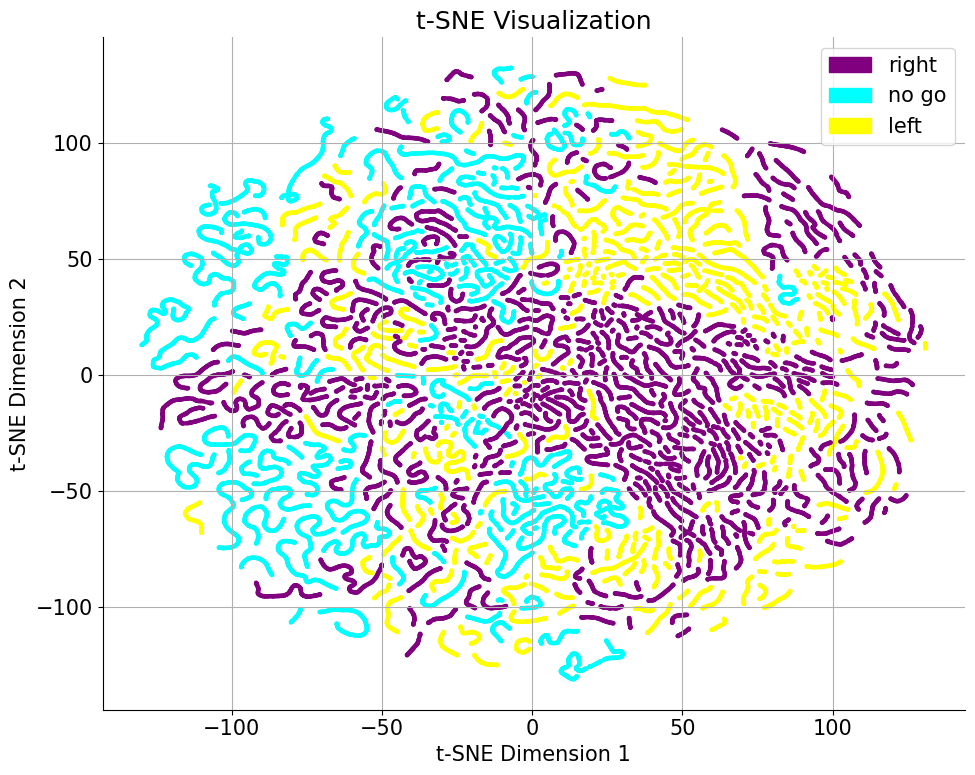

In [26]:
from sklearn.manifold import TSNE

# random_state fijo me va a dar siempre el mismo grafico
# perplexity es el numero de vecinos a considerar durante la optimizacion
tsne = TSNE(n_components=2, perplexity=20, random_state=9)
tsne_results = tsne.fit_transform(flattened_data)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5, c=colores, alpha=0.9)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color='purple'), 
                    plt.Rectangle((0,0),1,1, color='cyan'),
                    plt.Rectangle((0,0),1,1, color='yellow')],
           labels=['right', 'no go', 'left'])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

#### Al realizar el gráfico de t-SNE utilice un random state fijo con intención de que correr múltiples veces el bloque de código no produzca resultados distintos. De todas formas, previo a esto, provee ejecutar el bloque retiradas veces y siempre da una forma parecida. La misma tiende a ser continuamente algo símil a una nube llena de líneas finitas, como si fuera una corteza neuronal, al cambiar la perplexity se incrementa o decrementa la longitud de dichas líneas. Se puede ver claramente cómo diferentes zonas e líneas se ven divididas por los colores particulares. Son distinguibles distintas zonas donde prevalecen no-go (centro tirando para la izquierda), right (centro tirando para la der.) y left (prácticamente solo a la derecha).

# UMAP

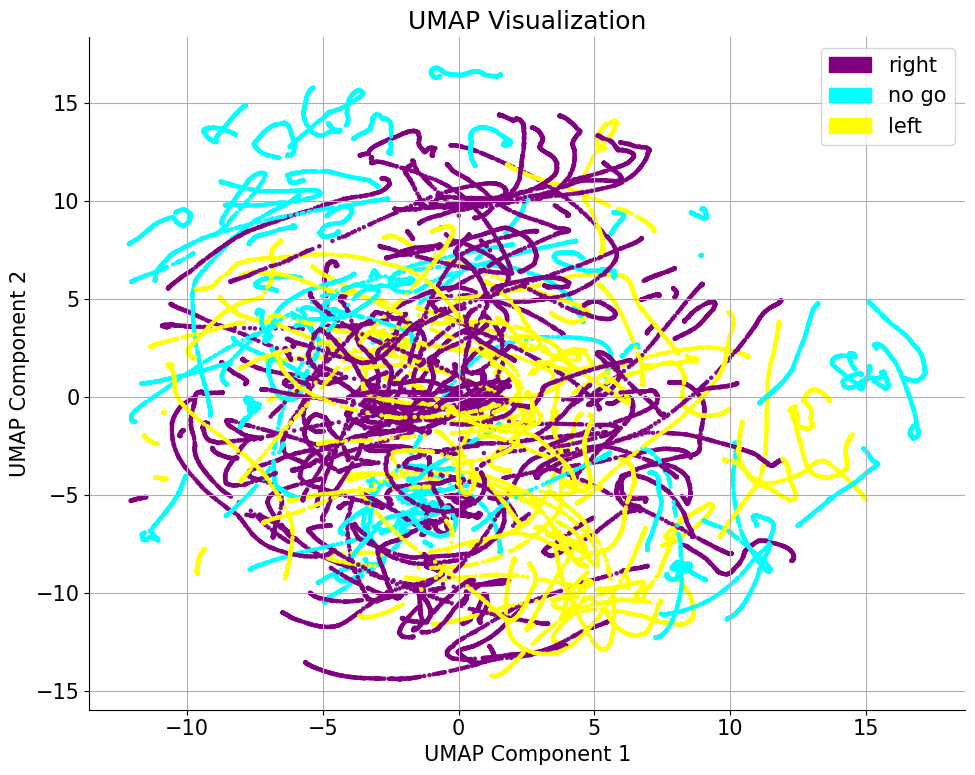

In [29]:
from umap import UMAP

umap_ = UMAP()
umap_results = umap_.fit_transform(flattened_data)

plt.figure(figsize=(10, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], s=5, alpha=0.9, c=colores)
plt.legend(handles=[plt.Rectangle((0,0),1,1, color='purple'), 
                    plt.Rectangle((0,0),1,1, color='cyan'),
                    plt.Rectangle((0,0),1,1, color='yellow')],
           labels=['right', 'no go', 'left'])
plt.title('UMAP Visualization')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

#### Al igual que t-SNE, cada ejecución da distinto. Aun así en las varias ejecuciones que realice, el resultado es siempre similar, una nube de líneas sin relación clara, similar a la nube del t-SNE, pero con líneas mucho más agresivas que se pisan entre sí. Si bien se pueden ver distintas agrupaciones según el tipo de trial, las líneas se pisan entre sí en prácticamentetodo todo el gráfico, por lo que no está claro si dichos clústers son realmente clústers.

# ¿Qué tipo de relaciones ve entre las variables? (ej. Variables que están correlacionadas, clusters y relaciones entre ellos, etc.)
### Las relaciones fueron explicadas debajo de los gráficos

# ¿Cómo varían los resultados entre las herramientas? 

### Tanto PCA como t-SNE dieron resultados que pude analizar, es decir, se notaba cómo se formaban agrupaciones por cada trigger. El cual no fue el caso de UMAP, que daba una nube donde no había relaciones aparentes entre los puntos de mismos colores.
##### PCA
- Ventajas:
    - Es mucho más rápido que los otros 2, teniendo en cuenta que el set de puntos es grande esto lo hace una buena opción
    - Los resultados no varían como en t-SNE o UMAP
- Desventajas:
    - Las descomposiciones son lineales, por lo cual no es fácil capturar información no lineal

##### t-SNE
- Desventajas:
    - Alto tiempo de ejecución, sobre todo si sé varía la perplexity para que tenga en cuenta muchos vecinos
    - Los resultados varían siempre, por eso, para hacer el análisis tuve que fijar la seed

##### UMAP
- Ventajas:
    - El tiempo de ejecución es menor a t-SNE, aunque sigue siendo mayor a PCA
- Desventajas:
    - Quizás mi incapacidad de interpretar el resultado se debe a que no conozco tanto el método, a diferencia de PCA por ejemplo.
    - Al igual que t-SNE los resultados varían con cada ejecución.